### 1. Load libraries/ data
#### 1.1. Load libraries

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA 
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold,cross_val_score, GridSearchCV)
from collections import Counter
from sklearn import metrics
import warnings

from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline 
warnings.filterwarnings('ignore')

#### 1.2. Load and explore the shape of the dataset

In [2]:
column_names = ['ID', 'RI', 'Na', 'Mg',' Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'glass_type']
df = pd.read_csv('./glass.data', sep=',', header=None, names=column_names)
print(df.shape)

(214, 11)


In [3]:
df.head()

,ID,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
df.drop(['ID'], axis=1, inplace=True)

In [5]:
features = df.columns[:-1].tolist()

In [6]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [7]:
df.dtypes

RI            float64
Na            float64
Mg            float64
 Al           float64
Si            float64
K             float64
Ca            float64
Ba            float64
Fe            float64
glass_type      int64
dtype: object

###  2. Data Summary
#### 2.1. Descriptive statistics
Let's first summarize the distribution of the numerical variables

In [8]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


The features are not on the same scale. For example Si has a mean of 72.65 while Fe has a mean value of 0.057
#### Features should be on the same scale for machine learning algorithms to converge smoothly
Now let's take a look at the distribution of the glass types

In [9]:
df['glass_type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: glass_type, dtype: int64

The dataset looks imbalanced. The glasses of types 1 and 2 makeup majority of the instances in the glass types.

#### 2.2. Data visualization

#### 2.2.1. Univariate Plots

Let have a look at the distribution of the different features of this dataset.

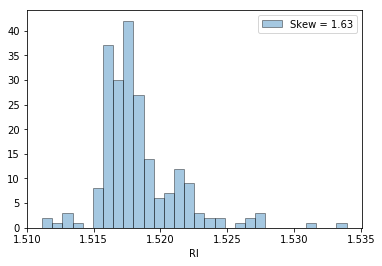

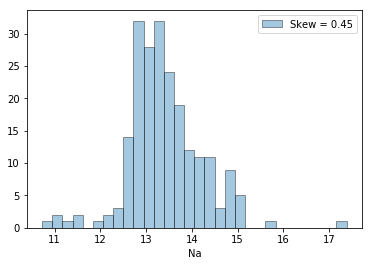

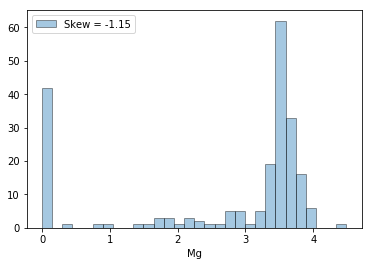

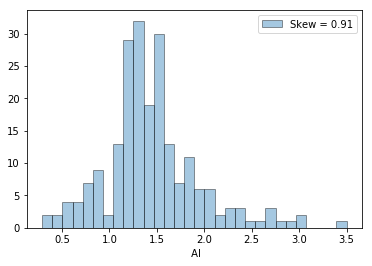

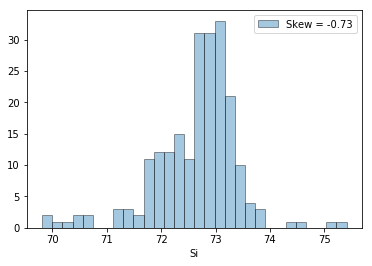

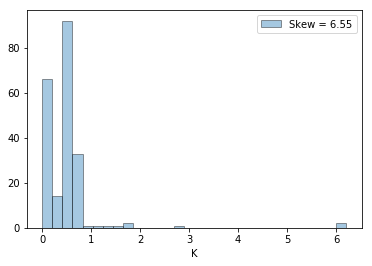

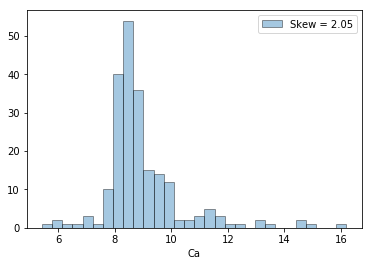

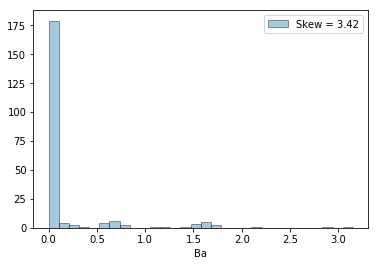

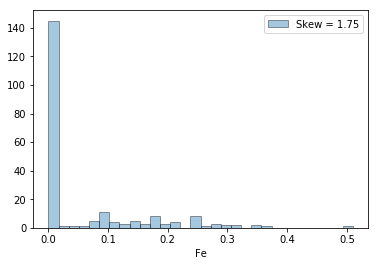

In [10]:
for f in features:
    skew = df[f].skew()
    sns.distplot(df[f], kde= False, label='Skew = %.2f' %(skew), bins=30, hist_kws=dict(edgecolor="k"))
    plt.legend(loc='best')
    plt.show()

The features don't appear to be normally distributed
- Fe, Ba, Ca and K exhibit the highest skew coefficients
- The distribution of K, Fe and Ba seem to contain outliers

In [11]:
# Function to determine observations with more than one outlier
def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices 
    corresponding to the observations containing more than 2 outliers
    based on 1.5* the interquartile range 
    """
    outlier_indices = []
    
    for col in df.columns.tolist():
        Q1 = np.percentile(df[col], 25)
        
        Q3 = np.percentile(df[col],75)
        
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

out_num = len(outlier_hunt(df[features]))
print('The dataset contains %d observations with more than 2 outliers' %(out_num))  

The dataset contains 14 observations with more than 2 outliers


We will get rid of these outliers to improve the efficiency of the algorithm.

Let's have a look at the boxplots for the several distributions.

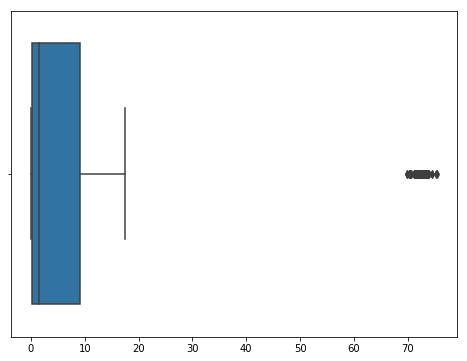

In [12]:
plt.figure(figsize=(8,6))
sns.boxplot(df[features])
plt.show()

The high value in the 70's correspond to the Silicon as we saw earlier, since glass is mostly Silicon. We will take care of this via normalization.

#### 2.2.2. Multivariate plots

Let's see the correlation between the various features.

<Figure size 576x576 with 0 Axes>

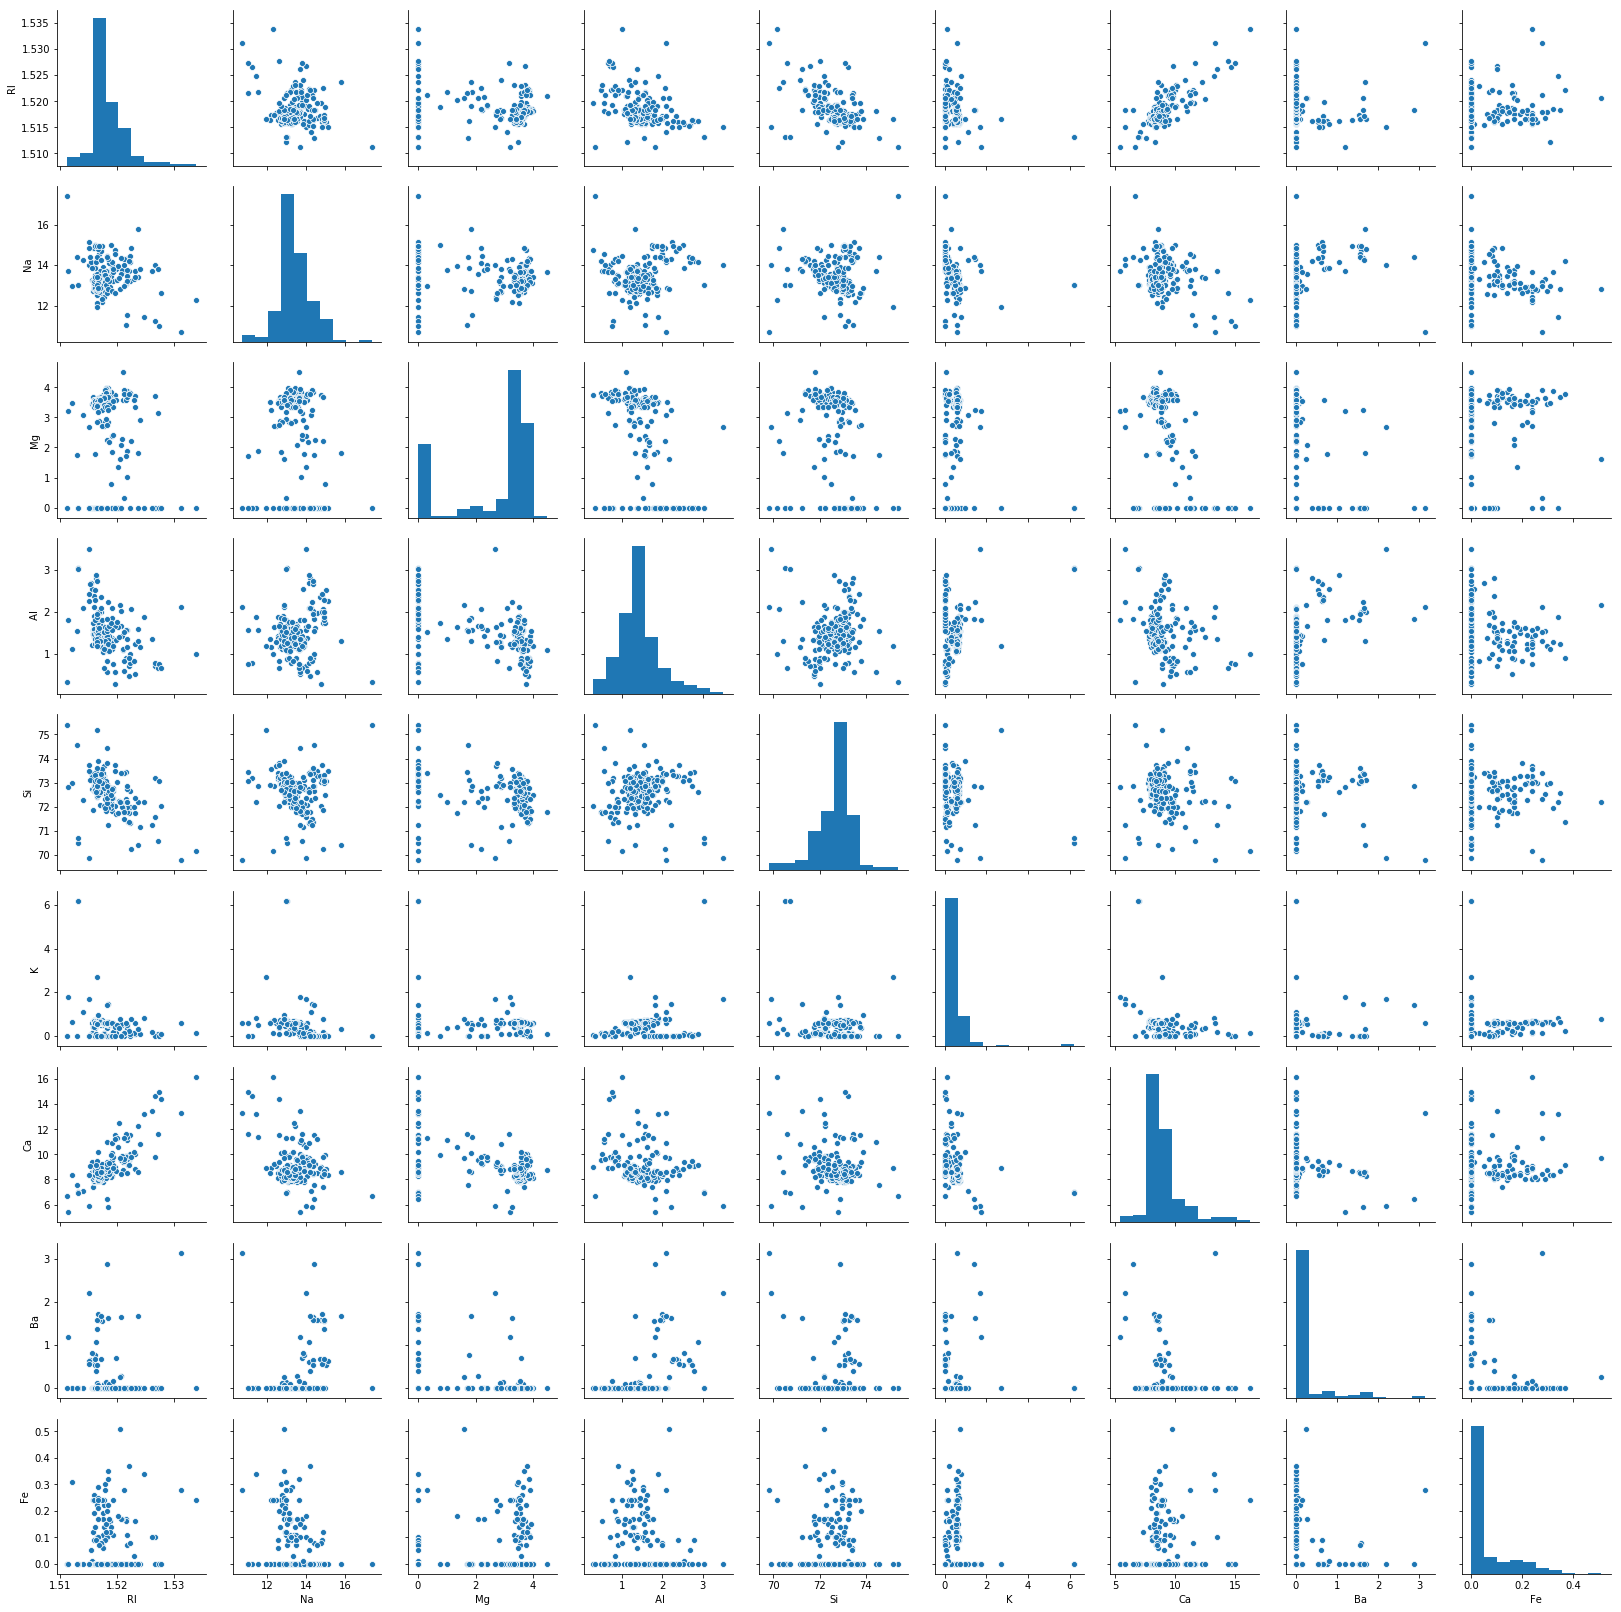

In [13]:
plt.figure(figsize=(8,8))
sns.pairplot(df[features])
plt.show()

Let's see the heatmap of the correlations.

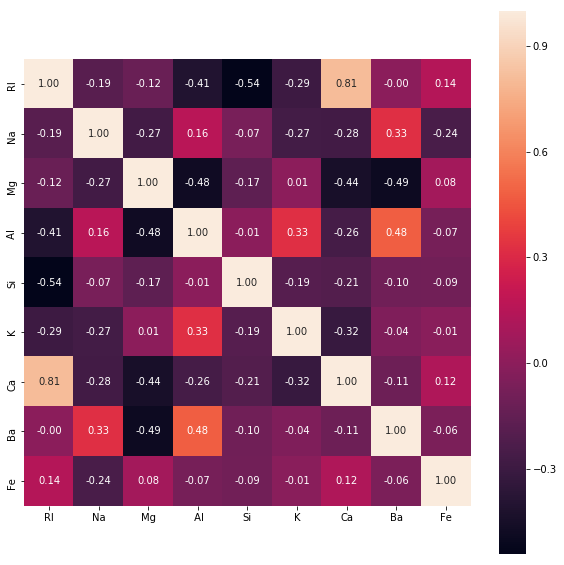

In [14]:
corr = df[features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           xticklabels= features, yticklabels= features)
plt.show()

#### Observations
- There seems to be a strong correlation between RI and Ca
- RI and Si are negatively correlated
- We can perform perform Principal component analysis (PCA) to decorrelate some of the input features that are strongly correlated

### 3. Data Preparation
#### 3.1. Data Cleaning

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
RI            214 non-null float64
Na            214 non-null float64
Mg            214 non-null float64
 Al           214 non-null float64
Si            214 non-null float64
K             214 non-null float64
Ca            214 non-null float64
Ba            214 non-null float64
Fe            214 non-null float64
glass_type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


- This dataset is clean
- There aren't any missing values in it.

#### Let us now remove the observations having multiple outliers

In [16]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


Removing observations with multiple outliers (more than 2) leaves us with 200 observations.

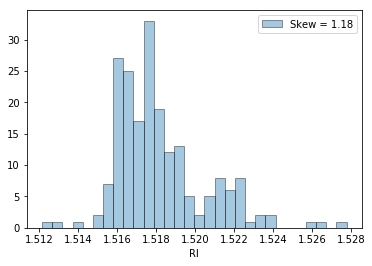

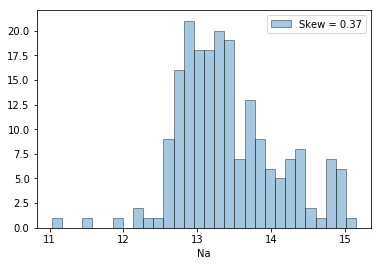

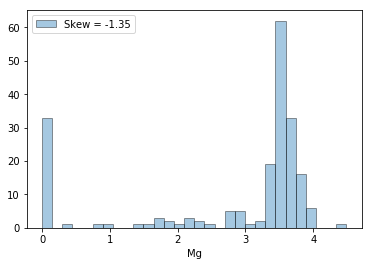

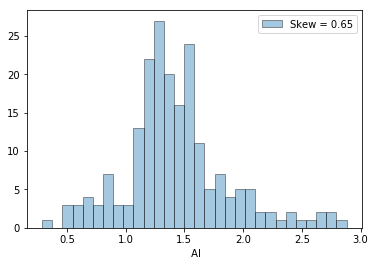

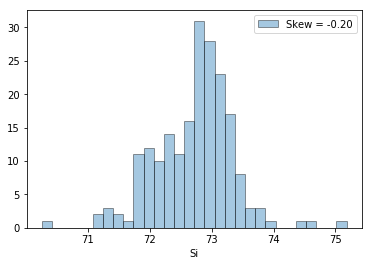

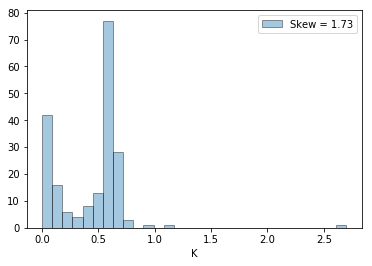

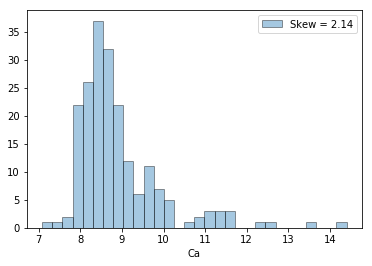

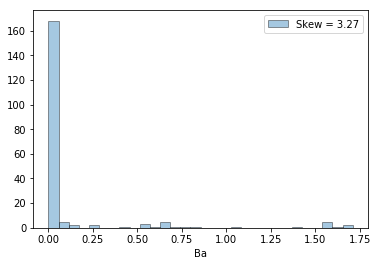

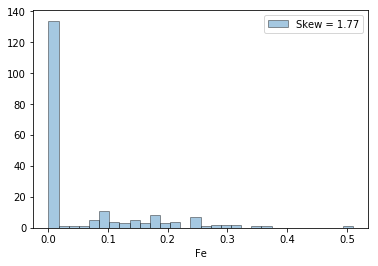

In [17]:
for f in features:
    skew = df[f].skew()
    sns.distplot(df[f], kde=False, label='Skew = %.2f' %(skew), bins=30, hist_kws=dict(edgecolor="k"))
    plt.legend(loc='best')
    plt.show()

#### The skewness values are less as compared to the original dataset plotted previously

In [18]:
df['glass_type'].value_counts()

2    70
1    70
7    25
3    17
5    10
6     8
Name: glass_type, dtype: int64

Let's now plot a distribution of the Types.

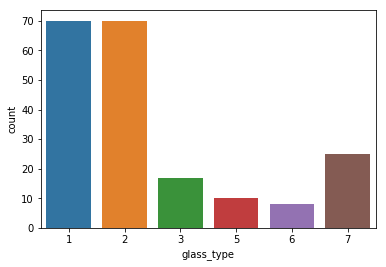

In [19]:
sns.countplot(df['glass_type'])
plt.show()

#### 3.2. Split-out validation dataset

In [20]:
# Define X as features and y as lablels
X = df[features] 
y = df['glass_type'] 
# set a seed and a test size for splitting the dataset 
seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

#### Train a KNN classifier to serve as the baseline.

In [21]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

0.65


#### 3.3. Data transformation

#### Let's explore dimensionality reduction techniques and see if that improves the accuracy!

                      P1    P2    P3    P4    P5    P6    P7   P8   P9
Explained_Variance  2.47  0.96  0.56  0.14  0.06  0.04  0.01  0.0  0.0


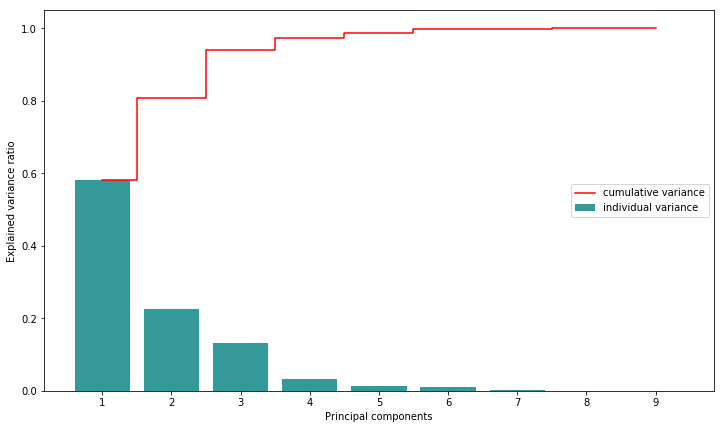

In [22]:
# Performing PCA
X_var = df[features]
pca = PCA(random_state = seed)
pca.fit(X_var)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
var_df = pd.DataFrame(pca.explained_variance_.round(2), index=["P" + str(i) for i in range(1,10)],
                      columns=["Explained_Variance"])
print(var_df.T)
plt.figure(figsize=(12,7))
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance', color='teal', alpha = 0.8)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance', color='red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()

In [23]:
# We will preserve the first 5 PCs since it explains over 95% of the variance
pca_red = PCA(n_components=5)
X_reduced = pca_red.fit_transform(X_var)

In [24]:
# Separating the response (y) and explanatory (x) variables after performing PCA
X = X_reduced
y = y = df['glass_type'] 

In [25]:
# Splitting the dataset into test and training with 80% for training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

# Check whether the train and test have instances of all the glass types
print(np.unique(y_train))
print(np.unique(y_test))

[1 2 3 5 6 7]
[1 2 3 5 6 7]


### 4. Baseline model
#### Train a KNN classifier to serve as the baseline.

In [26]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

0.675


#### The accuracy is better in the new principal component space by 2.5%. We will stick to this for the subsequent analysis!

### 5. Parameter tuning with cross validation
#### Let's now try changing the number of neighbours.

In [27]:
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

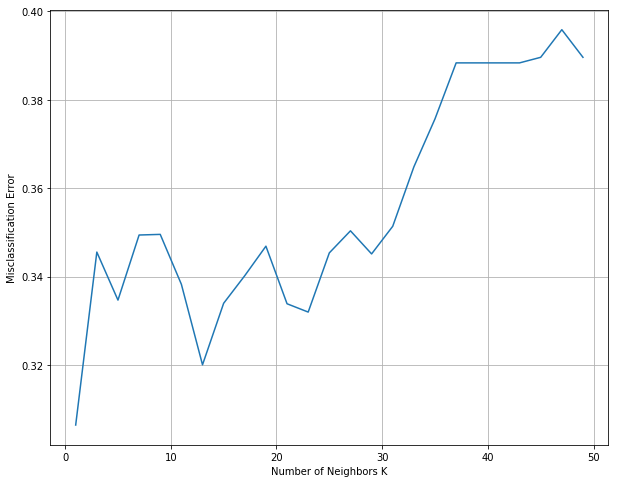

In [28]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.figure(figsize=(10,8))
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.grid()
plt.show()

#### The least misclassification error is observed for k = 12.
- We are ignoring the initial few values with lower the number of neighbours to avoid the case of overfitting

### 6. Applying Diagnostics: to improve the performance of the algorithm
A simple and effective way to remedy skewed class distributions is by implementing weighted voting. The class of each of the K neighbors is multiplied by a weight proportional to the inverse of the distance from that point to the given test point. This ensures that nearer neighbors contribute more to the final vote than the more distant ones.
#### We will acheive this by specifying that the weights is proportional to the distance while training the model

#### Without weighted voting for k = 12

In [29]:
# instantiate learning model (k = 12)
knn = KNeighborsClassifier(n_neighbors=12)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

0.575


#### With weighted voting for k = 12

In [30]:
# instantiate learning model (k = 12)
knn = KNeighborsClassifier(n_neighbors=12, weights='distance')

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

0.65


#### The accuracy improves by 7.5% by implementing weighted voting

Changing the distance metric for different applications may help improve the accuracy of the algorithm. 
#### Let's try the Manhattan distance as opposed to Eucleadian distance

In [31]:
## Manhattan Distace
def mydist(X1, X2):
    return (abs(X1[0] - X2[0]) + abs(X1[1] - X2[1]))

In [32]:
# instantiate learning model (k = 12)
knn = KNeighborsClassifier(n_neighbors=12, weights='distance', metric=mydist)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

0.625


#### The accuracy decreased by 2.5%. Let's try Manhattan distance without the weighted voting!

In [33]:
# instantiate learning model (k = 12)
knn = KNeighborsClassifier(n_neighbors=12, metric=mydist)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

0.65


#### This still shows an improvement in the accuracy as compared to the base case of 57.5%. Using Mahattan diatnce and weighted voting together doesn't show further increase in accuracy compared to when being used individually.

#### We had earlier seen that the classes appeared to be imbalanced. Let's check if using StratifiedKFold helps further with the accuracy. We will stick to weighted voting and Manhattan distance for this.

In [34]:
knn = KNeighborsClassifier(n_neighbors=12, weights='distance', metric=mydist)
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
cv_results = cross_val_score(knn, X_train, y_train, cv=kfold, scoring = 'accuracy') 
cv_results.mean()

0.6726884944261105

#### The accuracy further improved by 2.26%

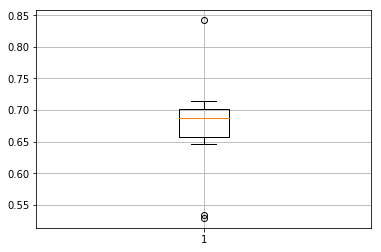

In [35]:
plt.boxplot(cv_results)
plt.grid()
plt.show()

### Hyper parameters tuning of knn

In [36]:
#With Hyper Parameters Tuning
#10-14,kNearestNeighbors

#making the instance
model = KNeighborsClassifier(n_jobs=-1)
#Hyper Parameters Set
params = {'n_neighbors':[10, 11, 12, 13, 14],
          'leaf_size':[1,2,3],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=1)
#Learning
model1.fit(X_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(X_test)
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(prediction,y_test))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,y_test))

Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 12, 'weights': 'distance'}
Accuracy: 0.65
Confusion Metrix:
 [[ 8  6  2  0  0  0]
 [ 1 10  0  0  0  1]
 [ 0  0  1  0  0  0]
 [ 0  2  0  1  0  1]
 [ 0  1  0  0  1  0]
 [ 0  0  0  0  0  5]]


In [37]:
from sklearn.metrics import classification_report
expected   = y_test
predicted  = model1.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["building_windows_float_processed",\
                                "building_windows_non_float_processed","vehicle_windows_float_processed",\
                                "vehicle_windows_non_float_processed","containers","tableware","headlamps"])
print(classificationReport)

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.50      0.89      0.64         9
building_windows_non_float_processed       0.83      0.53      0.65        19
     vehicle_windows_float_processed       1.00      0.33      0.50         3
 vehicle_windows_non_float_processed       0.25      1.00      0.40         1
                          containers       0.50      1.00      0.67         1
                           tableware       1.00      0.71      0.83         7

                         avg / total       0.78      0.65      0.66        40



- Precision is the number of correct positive results divided by the number of all positive results i.e. how many of the type of glass we identified actually belong to that type of glass
- precision = true positives / (true positives + false positives)
- Recall is the number of correct positive results divided by the number of positive results that should have been returned i.e. how many of the type of glasses identified did we accurately predict
- recall = true positives / (false negatives + true positives)
- The F1 score is a measure of a test's accuracy. It considers both the precision and the recall of the test to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0
- F1 score = 2 x (precision x recall) / (precision + recall)